In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import itertools
from tqdm import tqdm, trange

from agents.dqn import DoubleDQNAgent, QNetwork
from environment.env import GridEnvDeform, POMDPWrapper_v0, create_maze
import matplotlib.pyplot as plt

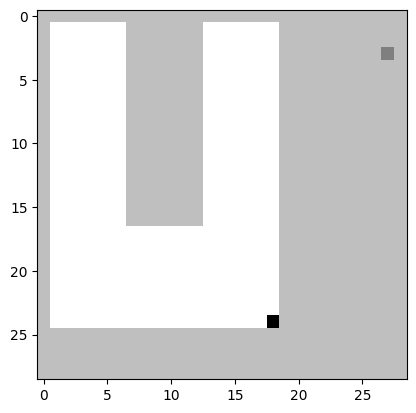

States: 236196, Actions: 4, Observations 32, Thetas [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]



In [2]:
# maze size
N = 2

# thetas deformations (range(a,b),range(c,d))
l0 = 1
h0 = 10
l1 = 1
h1 = 10

maze = np.load(f"maze/maze_{N}.npy")
env = GridEnvDeform(maze,l0,h0,l1,h1)
env.render()

states = [((x,y,phi),(i,j)) for x in range(1,env.max_shape[0]-1) for y in range(1,env.max_shape[1]-1) for phi in range(4) for i in range(l0,h0) for j in range(l1,h1)] 
actions = [0,1,2,3]
obs = list(itertools.product([0,1], repeat=5))
thetas = [(i,j) for i in range(l0,h0) for j in range(l1,h1)]

state_dict = {state: i for i, state in enumerate(states)}
obs_dict = {obs : i for i, obs in enumerate(obs)}

# Actions are: 0-listen, 1-open-left, 2-open-right
lenS = len(states)
lenA = len(actions)
lenO = len(obs)

print(f"States: {lenS}, Actions: {lenA}, Observations {lenO}, Thetas {thetas}\n")

T = torch.load(f"models/T_maze_{N}.pt", weights_only=True)
R = torch.load(f"models/R_maze_{N}.pt", weights_only=True)
O = torch.load(f"models/O_maze_{N}.pt", weights_only=True)


# fully observable train

notice that the train is fully observable, in the following cell each transition is \
(1) the current state \
(2) the action taken \
(3) the reward received \
(4) the next state \
(5) the done flag

where current state is an int (range(0, len(states)))

# tabular q-learning

In [3]:
# from agents.tabular_qlearning import q_learning

# Q = q_learning(env, 50000,300, 0.8, 0.95, 0.5, states_dict=state_dict,evaluate_every=1000)

# np.save(f"agents/tabularQ_maze_{N}_10deformations_init1.npy", Q)

Q = np.load(f"agents/tabularQ_maze_{N}_10deformations.npy")

In [4]:
state_value = np.max(Q,axis=1)


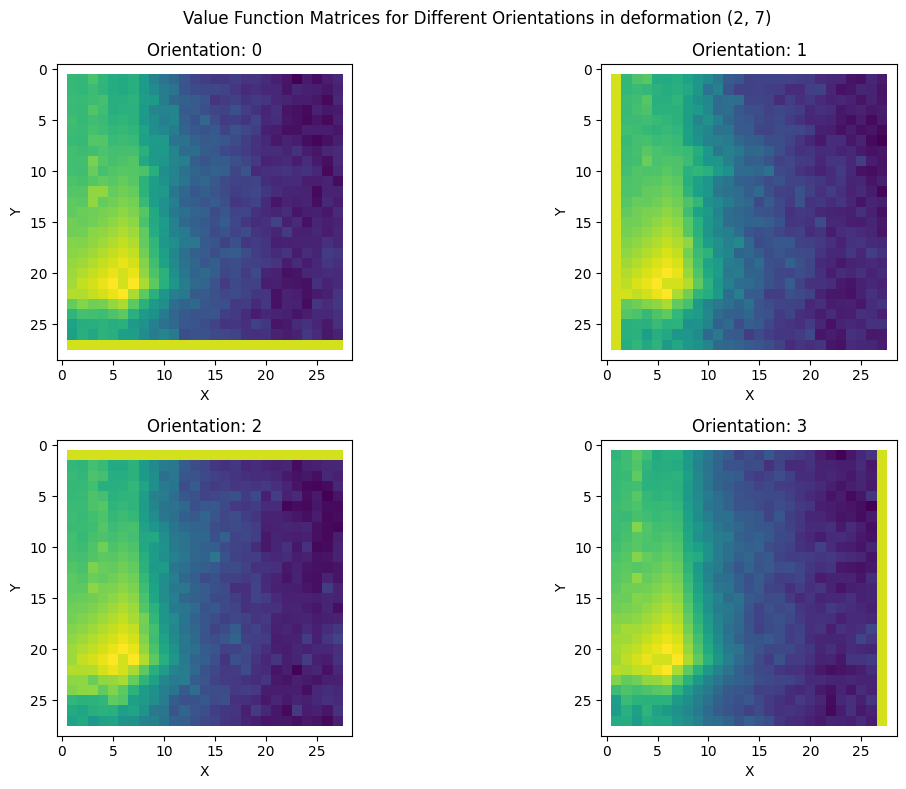

In [5]:
# fix orientation and deformation
deformation = (2, 7)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for orientation in range(4):
    Value_matrix_plot = np.zeros(env.maze.shape) - np.inf
    for s, state in enumerate(states):
        if state[1] == deformation and state[0][2] == orientation:
            Value_matrix_plot[state[0][0], state[0][1]] = state_value[s]
    
    ax = axes[orientation]
    ax.imshow(Value_matrix_plot)
    ax.set_title(f"Orientation: {orientation}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

plt.suptitle(f"Value Function Matrices for Different Orientations in deformation {deformation}")
plt.tight_layout()
plt.show()

In [6]:
Value_matrix_plot[:, -2]

array([-inf,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
        -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
        -1.,  -1.,  -1.,  -1.,  -1.,  -1., -inf])

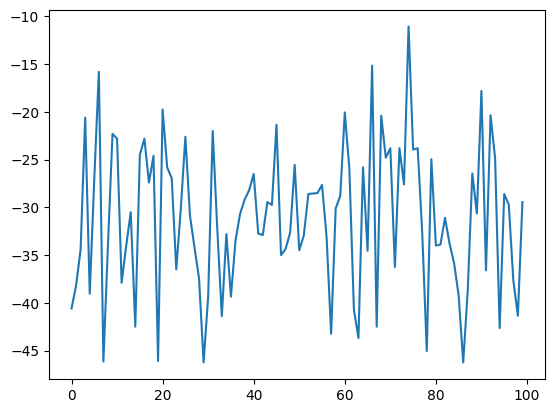

In [4]:
def eval_tabular(env : GridEnvDeform, Q, num_episodes=100, max_episode_steps=25, render=False):
    total_rewards = []

    for episode in range(num_episodes):
        s, _ = env.reset()
        state = state_dict[s]

        episode_reward = 0
        done = False
        c = max_episode_steps
        while not done and c > 0:
            if render:
                env.render()

            # Agent takes an action using a greedy policy (without exploration)
            action = np.argmax(Q[state])
            if render:
                print(f"State: {s}, Action: {action}")
            next_state, reward, done, _, info = env.step(action.item(), s, execute=render)
            state = state_dict[next_state]
            s = next_state

            episode_reward += reward
            
            if done or c == 1:
                total_rewards.append(episode_reward)
                # print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

            c -= 1
    avg_reward = np.mean(total_rewards)
    # print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    return avg_reward

rewards = [eval_tabular(env, Q, 10) for _ in range(100)]  
plt.plot(rewards)

In [5]:
eval_tabular(env, Q, 1000)

np.float64(-32.1005)

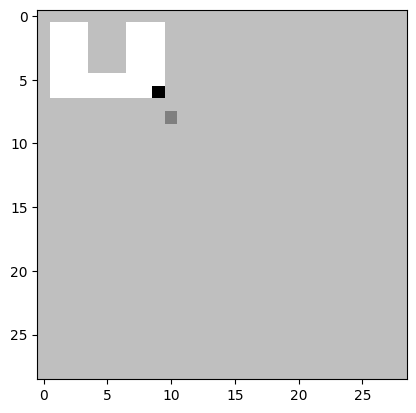

State: ((8, 10, 1), (3, 2)), Action: 2


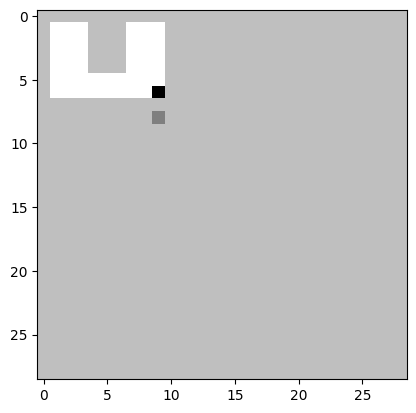

State: ((8, 9, 3), (3, 2)), Action: 1


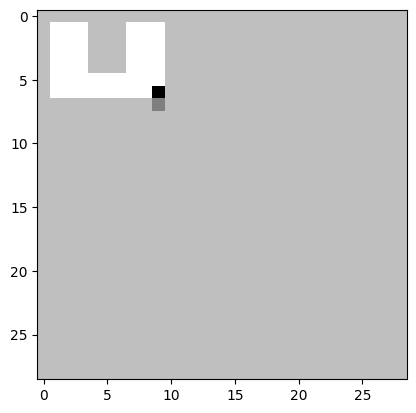

State: ((7, 9, 0), (3, 2)), Action: 0


np.float64(-3.0)

In [6]:
eval_tabular(env, Q, 1, max_episode_steps=10, render=True)

## train Q network to approximate the tabular Q function

In [10]:
model = QNetwork(5, 4)
epochs = 100
lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
criterion = nn.MSELoss()


Q = torch.tensor(Q,dtype=torch.float32)

# train the model
for epoch in trange(epochs):
    for s, y in zip(states, Q[:]):
        x = torch.tensor([item for sublist in s for item in sublist], dtype=torch.float32)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    
    scheduler.step()
    
    if epoch % 5 == 0:
        print(f'Epoch {epoch} loss: {loss.item()}')    


/tmp/ipykernel_43473/1555946012.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Q = torch.tensor(Q,dtype=torch.float32)
  0%|          | 0/100 [00:09<?, ?it/s]


KeyboardInterrupt: 

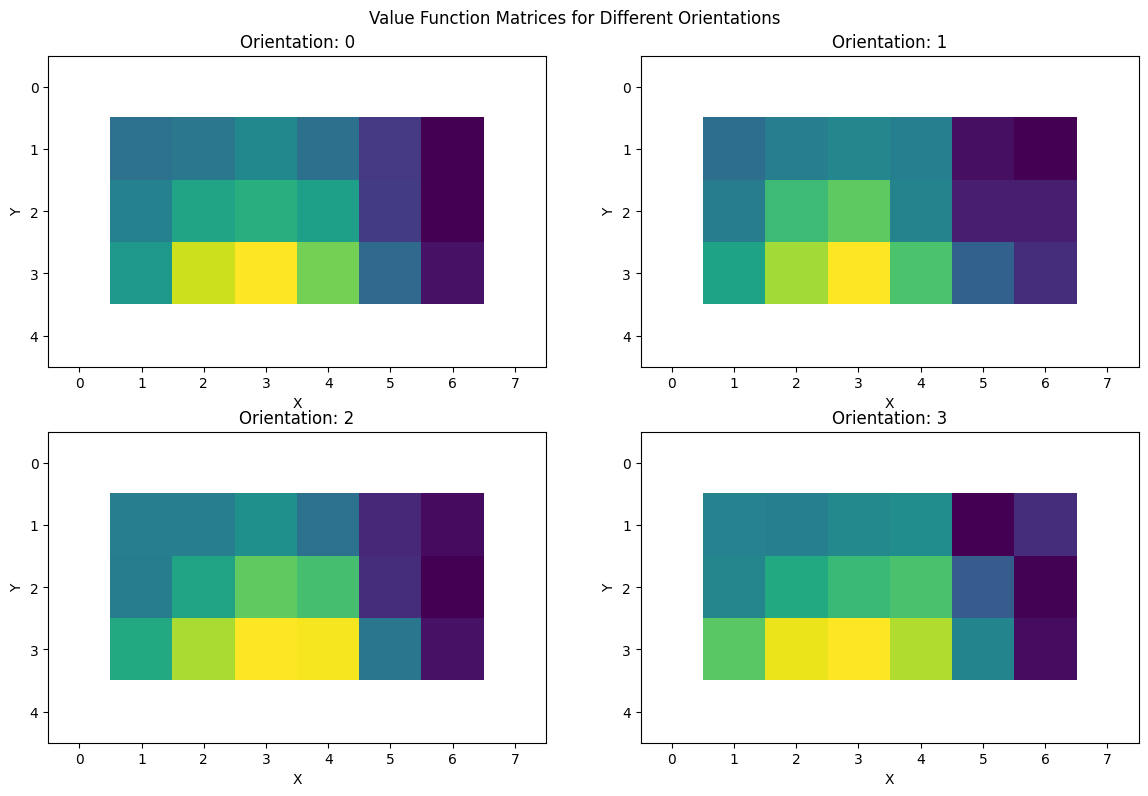

In [39]:
state_value = torch.zeros(lenS)
for s in range(lenS):
    state = torch.tensor([item for sublist in states[s] for item in sublist], dtype=torch.float32)
    state_value[s] = torch.max(model(state))


# fix orientation and deformation
deformation = (1, 1)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for orientation in range(4):
    Value_matrix_plot = np.zeros(env.maze.shape) - np.inf
    for s, state in enumerate(states):
        if state[1] == deformation and state[0][2] == orientation:
            Value_matrix_plot[state[0][0], state[0][1]] = state_value[s]
    
    ax = axes[orientation]
    ax.imshow(Value_matrix_plot)
    ax.set_title(f"Orientation: {orientation}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

plt.suptitle("Value Function Matrices for Different Orientations")
plt.tight_layout()
plt.show()

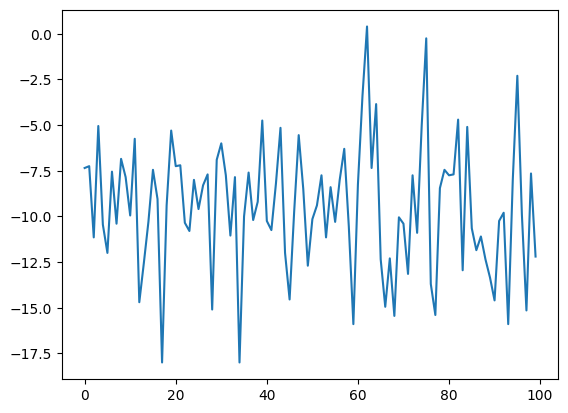

In [20]:
def evaluate_network(env : GridEnvDeform, model, num_episodes=10, max_episode_steps=25, render=False):
    total_rewards = []

    for episode in range(num_episodes):
        s, _ = env.reset()
        state = torch.tensor([item for sublist in s for item in sublist], dtype=torch.float32)

        episode_reward = 0
        done = False
        c = max_episode_steps
        while not done and c > 0:
            # Render the environment
            if render:
                env.render()

            # Agent takes an action using a greedy policy (without exploration)
            action = torch.argmax(model(state))
            if render:
                print(f"State: {s}")
                print(f"Action: {action.item()}")
            
            next_state, reward, done, _, info = env.step(action.item(),s, execute = render)

            state = torch.tensor([item for sublist in next_state for item in sublist], dtype=torch.float32)
            s = next_state

            episode_reward += reward
            
            if done or c == 1:
                total_rewards.append(episode_reward)
                # print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

            c -= 1
    avg_reward = np.mean(total_rewards)
    # print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    return avg_reward

rewards = [evaluate_network(env, model, 10) for _ in range(100)]
plt.plot(rewards)


In [21]:
evaluate_network(env, model, 1000)

np.float64(-9.986)

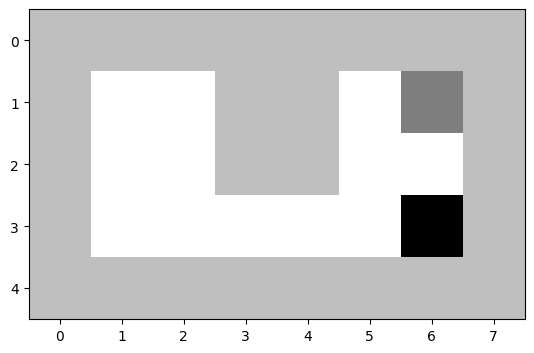

State: ((1, 6, 0), (2, 1))
Action: 2


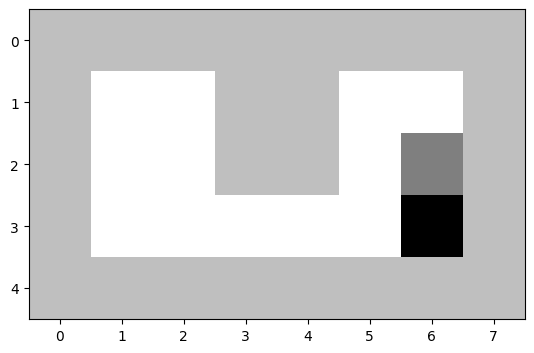

State: ((2, 6, 2), (2, 1))
Action: 0


np.float64(0.5)

In [42]:
evaluate_network(env, model, 1, max_episode_steps=10, render=True)

# train dqn 
optionally start with a pretrained model 

In [3]:
def evaluate_agent_training(env : GridEnvDeform, agent : DoubleDQNAgent, num_episodes=10):
    total_rewards = []

    for episode in range(num_episodes):
        s, _ = env.reset()
        state = torch.tensor([item for sublist in s for item in sublist], dtype=torch.float32)

        episode_reward = 0
        done = False
        c = 25
        while not done and c > 0:
            # Render the environment
            # env.render()

            # Agent takes an action using a greedy policy (without exploration)
            action = agent.choose_deterministic_action(state)
            next_state, reward, done, _, info = env.step(action,s)

            state = torch.tensor([item for sublist in next_state for item in sublist], dtype=torch.float32)
            s = next_state

            episode_reward += reward
            
            if done or c == 1:
                total_rewards.append(episode_reward)
                # print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

            c -= 1
    avg_reward = np.mean(total_rewards)
    # print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    return avg_reward


In [7]:
state_dim = 5
action_dim = 4

agent = DoubleDQNAgent(state_dim, action_dim, lr = 0.01, batch_size=64,target_update_freq=100, wandb=False)
agent.load("agents/double_dqn_maze_2_10deformations.pt")

/home/flaccagora/Desktop/RoboSurgery/src/agents/dqn.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.q_network.load_state_dict(torch.load(path))


In [ ]:
num_episodes = 2000
max_episode_steps = 200

rewards = []
evalrewards = []
progress_bar = tqdm.tqdm(total=num_episodes)

for episode in range(num_episodes):
    progress_bar.set_description(f"episode {episode}")

    s, _ = env.reset()
    state = torch.tensor([item for sublist in s for item in sublist], dtype=torch.float32)

    
    episode_reward = 0
    done = False
    
    steps = 0
    while not done and steps < max_episode_steps:
        action = agent.choose_action(state)
        
        s_ , reward, done , _, _ = env.step(action,s, execute=True)
        next_state = torch.tensor([item for sublist in s_ for item in sublist], dtype=torch.float32)
        s = s_

        agent.store_transition(state, action, reward, next_state, done)

        agent.train()
        state = next_state
        episode_reward += reward
        steps += 1      
      
    agent.update_epsilon()
    rewards.append(episode_reward)
            
    progress_bar.update(1)


    if episode != 0 and episode % 5 == 0:
        avg_reward = evaluate_agent_training(env, agent)
        evalrewards.append(avg_reward)
        # print(f"Episode {episode + 1}/{num_episodes}, Average Reward: {avg_reward}")

print("Training complete.")
agent.save("agents/double_dqn_maze_2_10deformations.pt")
print("evalrewards: ", evalrewards)

episode 1999: 100%|██████████| 2000/2000 [19:56<00:00,  2.19it/s]

Training complete.
evalrewards:  [np.float64(-40.1), np.float64(-34.65), np.float64(-29.35), np.float64(-30.6), np.float64(-27.5), np.float64(-36.45), np.float64(-26.9), np.float64(-31.2), np.float64(-31.45), np.float64(-29.55), np.float64(-30.85), np.float64(-31.45), np.float64(-26.7), np.float64(-28.25), np.float64(-20.65), np.float64(-40.25), np.float64(-26.25), np.float64(-23.15), np.float64(-27.75), np.float64(-31.0), np.float64(-27.7), np.float64(-31.65), np.float64(-35.4), np.float64(-29.65), np.float64(-30.95), np.float64(-34.55), np.float64(-30.4), np.float64(-36.0), np.float64(-40.05), np.float64(-36.35), np.float64(-33.9), np.float64(-22.65), np.float64(-36.5), np.float64(-28.35), np.float64(-36.4), np.float64(-38.9), np.float64(-27.8), np.float64(-33.35), np.float64(-37.35), np.float64(-37.25), np.float64(-29.0), np.float64(-22.35), np.float64(-33.25), np.float64(-39.95), np.float64(-34.1), np.float64(-36.8), np.float64(-26.45), np.float64(-36.6), np.float64(-36.5), np.floa

In [8]:
state_value = torch.zeros(lenS)
for s in range(lenS):
    state = torch.tensor([item for sublist in states[s] for item in sublist], dtype=torch.float32)
    state_value[s] = torch.max(agent.q_network(state))

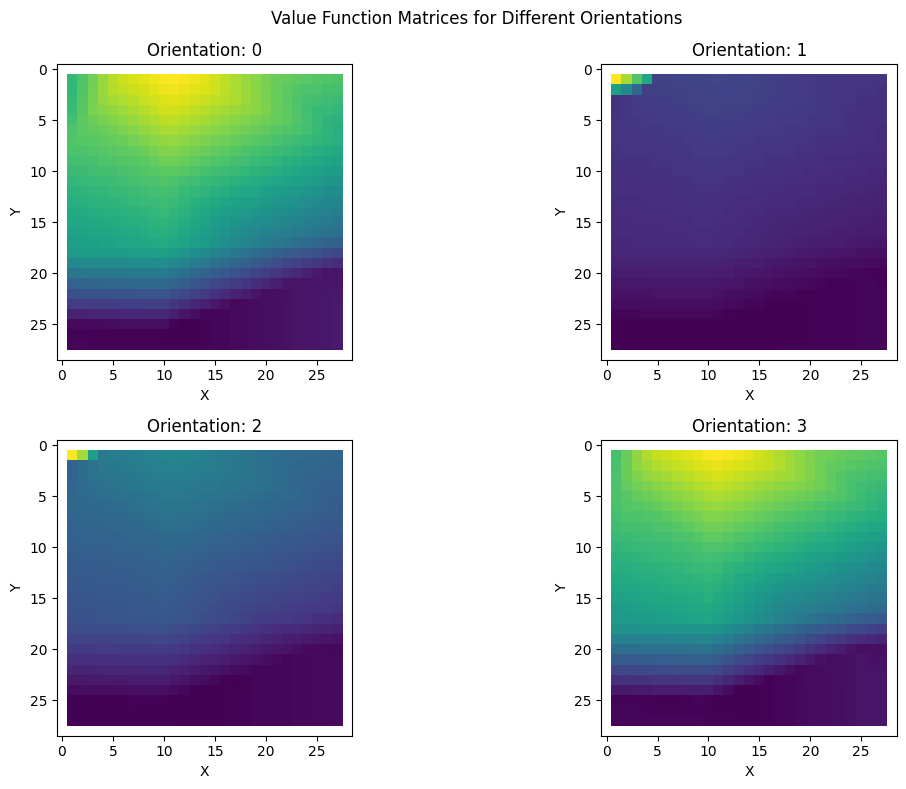

In [10]:

# fix orientation and deformation
deformation = (2, 1)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for orientation in range(4):
    Value_matrix_plot = np.zeros(env.maze.shape) - np.inf
    for s, state in enumerate(states):
        if state[1] == deformation and state[0][2] == orientation:
            Value_matrix_plot[state[0][0], state[0][1]] = state_value[s]
    
    ax = axes[orientation]
    ax.imshow(Value_matrix_plot)
    ax.set_title(f"Orientation: {orientation}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

plt.suptitle("Value Function Matrices for Different Orientations")
plt.tight_layout()
plt.show()

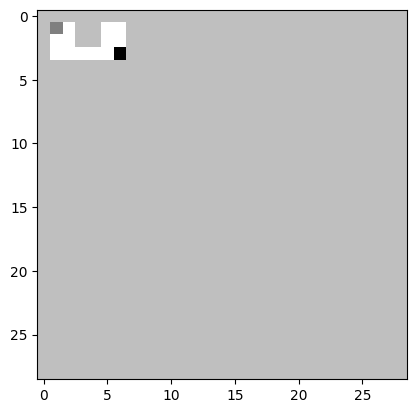

In [12]:
env.render(((1,1,0),(2,1)))

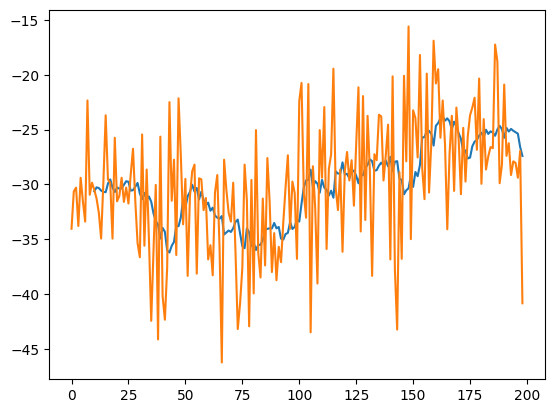

In [15]:
# plot evalrewards
rolling = [-np.inf for _ in range(10)] + [np.mean(evalrewards[i-10:i]) for i in range(10,len(evalrewards))]
plt.plot(rolling)
plt.plot(evalrewards)

In [16]:
evaluate_agent_training(env, agent, 1000)

np.float64(-27.8905)

# rendered evaluation


In [1]:
def evaluate_agent_training(env : GridEnvDeform, agent : DoubleDQNAgent, num_episodes=10,max_episode_steps=25, render=False):
    total_rewards = []

    for episode in range(num_episodes):
        s, _ = env.reset()
        state = torch.tensor([item for sublist in s for item in sublist], dtype=torch.float32)

        episode_reward = 0
        done = False
        c = max_episode_steps
        while not done and c > 0:
            if render:
                env.render()

            # Agent takes an action using a greedy policy (without exploration)
            action = agent.choose_deterministic_action(state)
            if render:
                print(f"State: {s}")
                print(f"Action: {action}")
            next_state, reward, done, _, info = env.step(action,s, execute=render)

            state = torch.tensor([item for sublist in next_state for item in sublist], dtype=torch.float32)
            s = next_state

            episode_reward += reward
            
            if done or c == 1:
                total_rewards.append(episode_reward)
                # print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

            c -= 1
    avg_reward = np.mean(total_rewards)
    # print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    return avg_reward

evaluate_agent_training(env, agent, 1, render=True)

NameError: name 'GridEnvDeform' is not defined

# transition check

In [ ]:
env_wrapper = POMDPWrapper_v0(env, agent, T, O, R)

In [9]:
# copy what is done in training:
# start from a random state chose an action and store the transition 
state, _ = env_wrapper.reset()
action = agent.choose_action([state])

obs, reward, done, info = env_wrapper.step(state, action)
next_state = info['actual_state'] # next true state (not observation or belief)

agent.store_transition([state], action, reward, [next_state], done)
state, action, reward, next_state, done


(109, 0, -1.0, 109, False)

In [41]:
state = ((1., 6., 0.),(1., 1.))
action = 3

In [43]:
state_dict[state]

40

In [45]:
state = 40

In [50]:
next_state = ((1., 5., 3.),(1., 1.))
next_state = state_dict[next_state]

((1, 6, 0), (1, 1))


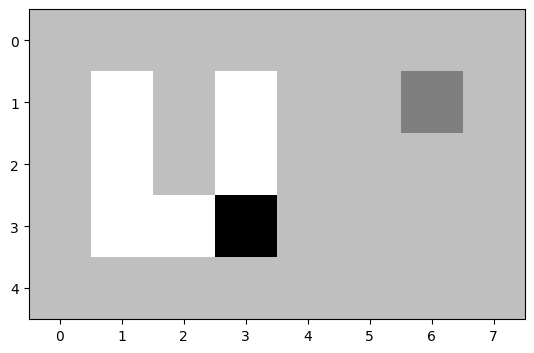

(((1, 5, 3), (1, 1)), -2, np.False_, False, {})


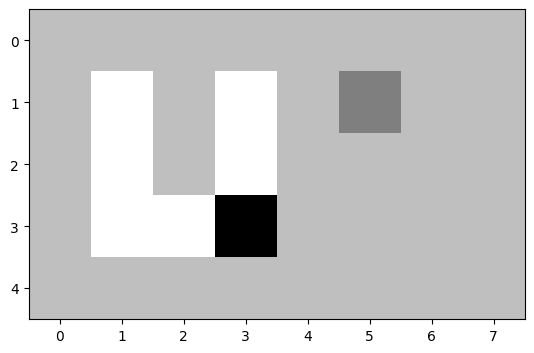

Training transition is correct


In [52]:
# set state and render
env.set_state(states[state])
print(states[state])
env.render()

# step and render
print(env.step(action, states[state], execute=True))
env.render()

# check if the transition is correct
assert env.get_state() == states[next_state]
print("Training transition is", "correct" if env.get_state() == states[next_state] else "incorrect")

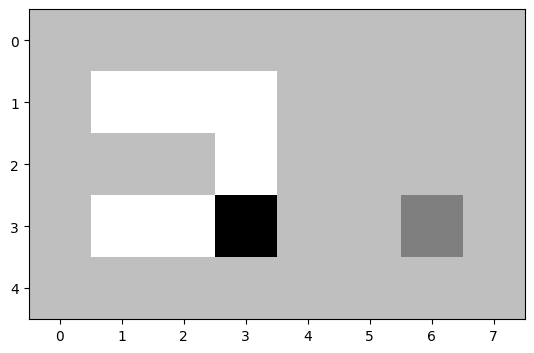

In [23]:
maze = create_maze(N)
env = GridEnvDeform(maze,l0,h0,l1,h1)
env.render()